In [44]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import random 
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import copy

import libmr
import scipy.spatial.distance as spd
import scipy as sp

In [10]:
data_dir = 'raw_TF4'
train_path = 'TF4_train'
test_path = 'TF4_test'
known_classes = ['Anastrepha', 'Bactrocera', 'Ceratitis', 'Rhagoletis']

### Select 5,000 removed images to make 5 unknown sets for cross validation

In [27]:
database_path = 'E:/Study/2021-s2/research project/Databases/Removed_Diptera/'
sample_path = 'C:/Users/dukes/ENGN8602 research/gcm-cf-main/osr/data/unknowns/'

# database = os.listdir(database_path)
# #randomly select 10000 removed images as unknown samples to OSR
# samples = random.sample(database, 5000)

# # Made folder to seperate images
# for i in range(1,6):
#     if not os.path.exists('unknowns/' + str(i)):
#         os.mkdir('unknowns/' +str(i))

# # copy the samples to make 10 unknown sets
# for i in range(1,6):
#     sub = samples[1000*(i-1):1000*i]
#     for name in sub:
#         shutil.copy(database_path+name, 
#                 sample_path+ str(i)+'/'+name)  

In [28]:
# transfer images of known classes between folders
def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in known_classes:
        transferBetweenFolders(source+'/'+label+'/', 
                               dest+'/'+label+'/', 
                               splitRate)

In [29]:
transferAllClassBetweenFolders(train_path, data_dir, 1.0)
transferAllClassBetweenFolders(test_path, data_dir, 1.0)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!


In [14]:
X=[]
Y=[]
l = len(known_classes)

# prepare the X,Y set of dataset
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(data_dir +'/'+ folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(l):
            if (folderName==known_classes[i]):
                Y.append(i)


# Organize file names and class labels in X and Y variables
for i in range(l):
    prepareNameWithLabels(known_classes[i])    

X=np.asarray(X)
Y=np.asarray(Y)

In [35]:
# Since we decided to use efficientNet-B2 as baseline model which requires 260*260 input
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((260,260)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((260,260)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
}

### Load the pre-trained best EfficientNet-B2 model as baseline

In [37]:
model = torch.load('Saved_model/Efficientnet2_10cv_4species_260.h5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Predict on the entire TF4, only record correctly classified samples

In [38]:
# build the dataloaders 
all_datasets = datasets.ImageFolder('raw_TF4/',data_transforms['train'])
all_dataloaders = torch.utils.data.DataLoader(all_datasets, batch_size=1,
                                             shuffle=True, num_workers=2)  

# store the AV and label of correctly classified samples
Feature_maps = []
Labels = []
for inputs, labels in all_dataloaders:
        inputs = inputs.to(device)
        label = labels.numpy()[0]
        
        pred = model(inputs)
        pred = pred.reshape(1,4)
        pred = pred.detach().cpu().numpy()[0]
        pred_label = np.argmax(pred)
        if label == pred_label:
            Labels.append(label)
            Feature_maps.append(pred)

In [39]:
def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:, 0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]

    return x_i

### Compute the MAV of each class

In [40]:
openset_classes = ['Anastrepha', 'Bactrocera', 'Ceratitis', 'Rhagoletis','Unknown']
seen_classes = [0,1,2,3]
alpha = len(seen_classes)
subFeature_maps = [get_class_i(Feature_maps, Labels, idx) for idx in seen_classes]

# compute the MAV of each class
means = [np.mean(k,0) for k in subFeature_maps]
print(len(subFeature_maps[0]))
print(len(subFeature_maps[1]))
print(len(subFeature_maps[2]))
print(len(subFeature_maps[3]))

655
1022
737
936


In [41]:
means

[array([ 7.8387704, -3.481935 , -3.6083407, -2.1003199], dtype=float32),
 array([-2.7030962,  7.56712  , -4.3138623, -3.124142 ], dtype=float32),
 array([-2.0463455, -3.10779  ,  8.464622 , -2.6256568], dtype=float32),
 array([-2.382833 , -3.2463467, -3.4481432,  7.850849 ], dtype=float32)]

### Define the way to compute distance between two AVs

In [45]:
def compute_distances(mean_feature, feature):
    eucos_dist, eu_dist, cos_dist = [], [], []
    for feat in feature:
        eu_dist += [spd.euclidean(mean_feature, feat)]
        cos_dist += [spd.cosine(mean_feature, feat)]
        eucos_dist += [spd.euclidean(mean_feature, feat)/200. + spd.cosine(
            mean_feature, feat)]
    distances = {'eucos': eucos_dist, 'cosine': cos_dist, 'euclidean': eu_dist}
    return distances

In [46]:
feature_distance = []
# compute the distance from every AV to MAV per class
for idx in seen_classes:
    subFeature_map = subFeature_maps[idx]
    distance = compute_distances(means[idx], subFeature_map)
    feature_distance.append(distance)

In [144]:
max(feature_distance[0]['euclidean'])

8.95879077911377

### Define the process to learn Weibull distribution on tail of distances

In [103]:
def weibull_tailfitting(
        mean, distance, tailsize=10, distance_type='eucos'):
    weibull_model = {}
    
    distance_scores = np.array(distance[distance_type])
    meantrain_vec = np.array(mean)

    weibull_model['distances_%s' % distance_type] = distance_scores
    weibull_model['mean_vec'] = meantrain_vec
    weibull_model['weibull_model'] = []
    # for channel in range(NCHANNELS):
    mr = libmr.MR()
    # print (distance_scores.shape)
    tailtofit = sorted(distance_scores)[-tailsize:]
    mr.fit_high(tailtofit, len(tailtofit))
    weibull_model['weibull_model'] += [mr]

    return weibull_model


def build_weibull(means, distance, tail, dis_type):
    weibull_model = {}
    for i in range(alpha): #alpha: len of classes
        weibull_model[i] = {}
        weibull = weibull_tailfitting(means[i], distance[i], tailsize=tail, distance_type=dis_type)
        weibull_model[i] = weibull
    return weibull_model

### Define the computation of Normalized Accuracy(NA) and Macro-averaging Open-set F-measure(maOSFM)

In [104]:
def computeMeasures(confusion, gamma, alpha):
    TP = []
    TN = []
    FPa = []  # FP oncly consider known classes
    FNa = []  # FN oncly consider known classes
    FPm = []  # FP consider unknown classes
    FNm = []  # FN consider unknown classes    
    
    # correctly rejected unknowns
    TU = confusion[alpha,alpha]
    # false rejected unknowns
    FU = sum(confusion[:,alpha]) + sum(confusion[alpha,:]) - 2*confusion[alpha,alpha]  
    
    for i in range(alpha): #0,1,2,3
        TP.append(confusion[i,i])
        a = confusion[i+1:alpha,i+1:alpha]
        b = confusion[:i,:i]
        if len(a)<=1 and len(b)>1:
            TN.append(int(sum(a)+sum(sum(b))))
        elif len(a)>1 and len(b)>1:
            TN.append(int(sum(sum(a))+sum(sum(b))))
        elif len(a)>1 and len(b)<=1:
            TN.append(int(sum(sum(a))+sum(b)))
        elif len(a)<=1 and len(b)<=1:
            TN.append(int(sum(a)+sum(b)))
        FNa.append(sum(confusion[i,:-1]) - confusion[i,i])
        FPa.append(sum(confusion[:-1,i]) - confusion[i,i])
        FNm.append(sum(confusion[i,:]) - confusion[i,i])
        FPm.append(sum(confusion[: ,i]) - confusion[i,i])   
        
    AKS = (sum(TP) + sum(TN))/(sum(TP) + sum(TN) + sum(FPa) + sum(FNa))
    AUS = TU/(TU+FU) 
    NA = gamma*AKS + (1-gamma)*AUS
    
    PPV_list = []
    TPR_list = []
    for j in range(alpha):
        ppv = TP[i]/(TP[i]+FPm[i])
        PPV_list.append(ppv)
        tpr = TP[i]/(TP[i]+FNm[i])
        TPR_list.append(ppv)
    PPV = sum(PPV_list)/alpha
    TPR = sum(TPR_list)/alpha
    F1 = (2*PPV*TPR)/(PPV+TPR)
    return AKS, AUS, NA, F1

### Build the testing set and experiments on distance measures ['eucos','cosine','euclidean']

In [107]:
tail = 20
dis_types = ['eucos','cosine','euclidean']

transferAllClassBetweenFolders(data_dir,test_path, 1.0)

for idx in range(1,6):
    # move unknown set to test folder
    transferBetweenFolders(sample_path+str(idx)+'/', test_path+'/Unknown/', 1.0)
    
    # build the test dataloader
    test_datasets = datasets.ImageFolder('TF4_test/',data_transforms['test'])
    test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=1,
                                                 shuffle=True, num_workers=2)      
    
    for dis_type in dis_types:
        # Based on tail size and distance type, build the weibull model for each class
        weibull_model = {}
        weibull_model = build_weibull(means, feature_distance, tail, dis_type)

        y_truth = []
        y_softmax = [] 
        thresholds = [0.98] # [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
        y_openmax =  [[]] # [[],[],[],[],[],[],[],[],[],[]]
        for test_inputs, test_labels in test_dataloaders:

            openmax = None
            softmax = None

            test_inputs = test_inputs.to(device)
            actual_class = test_labels.data.cpu().numpy()[0]
            pred_test = model(test_inputs)
            pred_test = pred_test.reshape(1,4)
            pred_test = pred_test.detach().cpu().numpy()[0]
            
            # results of normal SoftMax prediction
            softmax_probab = np.asarray(pred_test.ravel())
            
            # OpenMax algorithm
            revised_feature = []
            openmax_unknown = []
            for i in range(alpha): # 0 1 2 3
                mean = means[i]
                distance = 0
                if dis_type == 'eucos':
                    distance = spd.euclidean(mean, pred_test)/200. + spd.cosine( mean, pred_test) # default: eucos
                elif dis_type == 'cosin':
                    distance = spd.cosine( mean, pred_test)
                elif dis_type == 'euclidean':
                    distance = spd.euclidean(mean, pred_test)
                # probability to be an outlier
                fitscore = weibull_model[i]['weibull_model'][0].w_score(distance)
                w = 1-fitscore*((alpha-(i+1))/alpha)
                # probability to be in the class
                revised_feature += [pred_test[i]*w]
                # probability to be an outlier
                openmax_unknown += [pred_test[i]*(1-w)]

            revised_feature = np.asarray(revised_feature)
            openmax_unknown = np.asarray(openmax_unknown)
            unknowns = np.sum(openmax_unknown)
            prob_scores = revised_feature.tolist() + [unknowns]

            m = torch.nn.Softmax(dim=0)
            output = m(torch.as_tensor(prob_scores))
            predicted_class = torch.max(output).item()

            scores = []
            for i in range(len(prob_scores)): # 0 1 2 3
                scores += [np.exp(prob_scores[i])]
            total = np.sum(scores)
            openmax_probab = []
            for i in range(len(prob_scores)): # 0 1 2 3
                openmax_probab += [scores[i]/total]   
            softmax = np.argmax(softmax_probab)

    #         --------------maxPro of openMax-----------------        
            # print(np.argmax(openmax_probab))


            for i in range(len(thresholds)):
                openmax = np.argmax(openmax_probab)
                if openmax != 4 and predicted_class < thresholds[i]:
                    openmax = 4    
                y_openmax[i].append(openmax)

            y_truth.append(actual_class)  
            y_softmax.append(softmax)

        confusion = confusion_matrix(y_truth, y_openmax[0])
        print('Confusion Matrix\n')
        print(confusion)

        print('\nClassification Report\n')
        print(classification_report(y_truth, y_openmax[0], target_names= openset_classes)) 
        
        AKS, AUS, NA, F1 = computeMeasures(confusion, 0.5, alpha)  
        print("AKS is " + str(AKS))
        print("AUS is " + str(AUS))
        print("NA is " + str(NA))
        print("F1 is " + str(F1))
        
#         plt.figure(figsize=(5,5))
#         plot_confusion_matrix(confusion, class_names)      
    
    # move the used unknown set back 
    transferBetweenFolders(test_path+'/Unknown/',sample_path+str(idx)+'/', 1.0)  

    
transferAllClassBetweenFolders(test_path,data_dir, 1.0)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Confusion Matrix

[[626   0   0   1  44]
 [  0 969   0   3  71]
 [  0   1 717   0  29]
 [  1   0   1 910  36]
 [ 17  61  18  61 843]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.97      0.93      0.95       671
  Bactrocera       0.94      0.93      0.93      1043
   Ceratitis       0.97      0.96      0.97       747
  Rhagoletis       0.93      0.96      0.95       948
     Unknown       0.82      0.84      0.83      1000

    accuracy                           0.92      4409
   macro avg       0.93      0.92      0.93      4409
weighted avg       0.92      0.92      0.92      4409

AKS is 0.9989154853203192
AUS is 0.714406779661017
NA is 0.8566611324906681
F1 is 0.9333333333333333
Confusion Matrix

[[624   0   0   1  46]
 [  1 967   0   3  72]
 [  0   1 715   0  31]
 [  1   0   1 908  3

Confusion Matrix

[[628   0   0   1  42]
 [  1 970   0   3  69]
 [  0   1 723   0  23]
 [  1   0   1 910  36]
 [ 24  47  28  56 845]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.96      0.94      0.95       671
  Bactrocera       0.95      0.93      0.94      1043
   Ceratitis       0.96      0.97      0.96       747
  Rhagoletis       0.94      0.96      0.95       948
     Unknown       0.83      0.84      0.84      1000

    accuracy                           0.92      4409
   macro avg       0.93      0.93      0.93      4409
weighted avg       0.92      0.92      0.92      4409

AKS is 0.9987643833500657
AUS is 0.7222222222222222
NA is 0.8604933027861439
F1 is 0.9381443298969072
Confusion Matrix

[[626   0   0   1  44]
 [  0 969   0   3  71]
 [  0   1 717   0  29]
 [  1   0   1 910  36]
 [ 21  58  26  43 852]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.97      0.93     

### Build the testing set and experiments on tail size [10, 20, 30,40]

In [112]:
tail_size = [10, 20, 30, 40, 50,60,70,80]
dis_type = 'cosine'

transferAllClassBetweenFolders(data_dir,test_path, 1.0)

AKSs = []
AUSs = []
NAs = []
F1s = []
for idx in range(1,4):
    # move unknown set to test folder
    transferBetweenFolders(sample_path+str(idx)+'/', test_path+'/Unknown/', 1.0)
    
    # build the test dataloader
    test_datasets = datasets.ImageFolder('TF4_test/',data_transforms['test'])
    test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=1,
                                                 shuffle=True, num_workers=2)      
    
    for tail in tail_size:
        # Based on tail size and distance type, build the weibull model for each class
        weibull_model = {}
        weibull_model = build_weibull(means, feature_distance, tail, dis_type)

        y_truth = []
        y_softmax = [] 
        thresholds = [0.98] # [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
        y_openmax =  [[]] # [[],[],[],[],[],[],[],[],[],[]]
        for test_inputs, test_labels in test_dataloaders:

            openmax = None
            softmax = None

            test_inputs = test_inputs.to(device)
            actual_class = test_labels.data.cpu().numpy()[0]
            pred_test = model(test_inputs)
            pred_test = pred_test.reshape(1,4)
            pred_test = pred_test.detach().cpu().numpy()[0]
            
            # results of normal SoftMax prediction
            softmax_probab = np.asarray(pred_test.ravel())
            
            # OpenMax algorithm
            revised_feature = []
            openmax_unknown = []
            for i in range(alpha): # 0 1 2 3
                mean = means[i]
                distance = spd.cosine( mean, pred_test)
                # probability to be an outlier
                fitscore = weibull_model[i]['weibull_model'][0].w_score(distance)
                w = 1-fitscore*((alpha-(i+1))/alpha)
                # probability to be in the class
                revised_feature += [pred_test[i]*w]
                # probability to be an outlier
                openmax_unknown += [pred_test[i]*(1-w)]

            revised_feature = np.asarray(revised_feature)
            openmax_unknown = np.asarray(openmax_unknown)
            unknowns = np.sum(openmax_unknown)
            prob_scores = revised_feature.tolist() + [unknowns]

            m = torch.nn.Softmax(dim=0)
            output = m(torch.as_tensor(prob_scores))
            predicted_class = torch.max(output).item()

            scores = []
            for i in range(len(prob_scores)): # 0 1 2 3
                scores += [np.exp(prob_scores[i])]
            total = np.sum(scores)
            openmax_probab = []
            for i in range(len(prob_scores)): # 0 1 2 3
                openmax_probab += [scores[i]/total]   
            softmax = np.argmax(softmax_probab)

    #         --------------maxPro of openMax-----------------        
            # print(np.argmax(openmax_probab))


            for i in range(len(thresholds)):
                openmax = np.argmax(openmax_probab)
                if openmax != 4 and predicted_class < thresholds[i]:
                    openmax = 4    
                y_openmax[i].append(openmax)

            y_truth.append(actual_class)  
            y_softmax.append(softmax)

        confusion = confusion_matrix(y_truth, y_openmax[0])
        print('Confusion Matrix\n')
        print(confusion)

        print('\nClassification Report\n')
        print(classification_report(y_truth, y_openmax[0], target_names= openset_classes)) 
        
        AKS, AUS, NA, F1 = computeMeasures(confusion, 0.5, alpha)  
        AKSs.append(AKS)
        AUSs.append(AUS)
        NAs.append(NA)
        F1s.append(F1)
        print("AKS is " + str(AKS))
        print("AUS is " + str(AUS))
        print("NA is " + str(NA))
        print("F1 is " + str(F1))
        
#         plt.figure(figsize=(5,5))
#         plot_confusion_matrix(confusion, class_names)      
    
    # move the used unknown set back 
    transferBetweenFolders(test_path+'/Unknown/',sample_path+str(idx)+'/', 1.0)  

    
transferAllClassBetweenFolders(test_path,data_dir, 1.0)

Confusion Matrix

[[629   0   0   1  41]
 [  1 969   0   3  70]
 [  0   1 718   0  28]
 [  1   0   1 910  36]
 [ 26  64  20  61 829]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.96      0.94      0.95       671
  Bactrocera       0.94      0.93      0.93      1043
   Ceratitis       0.97      0.96      0.97       747
  Rhagoletis       0.93      0.96      0.95       948
     Unknown       0.83      0.83      0.83      1000

    accuracy                           0.92      4409
   macro avg       0.93      0.92      0.92      4409
weighted avg       0.92      0.92      0.92      4409

AKS is 0.9987624719622554
AUS is 0.705531914893617
NA is 0.8521471934279362
F1 is 0.9333333333333333
Confusion Matrix

[[626   0   0   1  44]
 [  0 969   0   3  71]
 [  0   1 717   0  29]
 [  1   0   1 910  36]
 [ 17  60  18  61 844]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.97      0.93      

Confusion Matrix

[[612   0   0   1  58]
 [  0 965   0   3  75]
 [  0   1 716   0  30]
 [  1   0   1 910  36]
 [ 16  32  15  46 891]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.97      0.91      0.94       671
  Bactrocera       0.97      0.93      0.95      1043
   Ceratitis       0.98      0.96      0.97       747
  Rhagoletis       0.95      0.96      0.95       948
     Unknown       0.82      0.89      0.85      1000

    accuracy                           0.93      4409
   macro avg       0.94      0.93      0.93      4409
weighted avg       0.93      0.93      0.93      4409

AKS is 0.9989090625730539
AUS is 0.7431192660550459
NA is 0.8710141643140499
F1 is 0.9479166666666666


In [127]:
a= np.array(AKSs).reshape([3,4])
b= np.array(AUSs).reshape([3,4])
c= np.array(NAs).reshape([3,4])
d= np.array(F1s).reshape([3,4])
print(a.mean(axis=0))
print(b.mean(axis=0))
print(c.mean(axis=0))
print(d.mean(axis=0))

[0.99876247 0.99891549 0.99891178 0.99890906]
[0.72283688 0.73022599 0.72907921 0.73060884]
[0.86079968 0.86457074 0.86399549 0.86475895]
[0.94437762 0.94437762 0.94437762 0.94437762]


### Experiments on threshold

In [129]:
tail = 40
dis_type = 'cosine'

transferAllClassBetweenFolders(data_dir,test_path, 1.0)

AKSs = []
AUSs = []
NAs = []
F1s = []
thresholds = [0, 0.2,0.4,0.6,0.9,0.92,0.94,0.96,0.98]


# move unknown set to test folder
transferBetweenFolders(sample_path+str(1)+'/', test_path+'/Unknown/', 1.0)

# build the test dataloader
test_datasets = datasets.ImageFolder('TF4_test/',data_transforms['test'])
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=1,
                                             shuffle=True, num_workers=2)      


# Based on tail size and distance type, build the weibull model for each class
weibull_model = {}
weibull_model = build_weibull(means, feature_distance, tail, dis_type)

y_truth = []
y_softmax = [] 

y_openmax =  [[],[],[],[],[],[],[],[],[]]
for test_inputs, test_labels in test_dataloaders:

    openmax = None
    softmax = None

    test_inputs = test_inputs.to(device)
    actual_class = test_labels.data.cpu().numpy()[0]
    pred_test = model(test_inputs)
    pred_test = pred_test.reshape(1,4)
    pred_test = pred_test.detach().cpu().numpy()[0]

    # results of normal SoftMax prediction
    softmax_probab = np.asarray(pred_test.ravel())

    # OpenMax algorithm
    revised_feature = []
    openmax_unknown = []
    for i in range(alpha): # 0 1 2 3
        mean = means[i]
        distance = spd.cosine( mean, pred_test)
        # probability to be an outlier
        fitscore = weibull_model[i]['weibull_model'][0].w_score(distance)
        w = 1-fitscore*((alpha-(i+1))/alpha)
        # probability to be in the class
        revised_feature += [pred_test[i]*w]
        # probability to be an outlier
        openmax_unknown += [pred_test[i]*(1-w)]

    revised_feature = np.asarray(revised_feature)
    openmax_unknown = np.asarray(openmax_unknown)
    unknowns = np.sum(openmax_unknown)
    prob_scores = revised_feature.tolist() + [unknowns]

    m = torch.nn.Softmax(dim=0)
    output = m(torch.as_tensor(prob_scores))
    predicted_class = torch.max(output).item()

    scores = []
    for i in range(len(prob_scores)): # 0 1 2 3
        scores += [np.exp(prob_scores[i])]
    total = np.sum(scores)
    openmax_probab = []
    for i in range(len(prob_scores)): # 0 1 2 3
        openmax_probab += [scores[i]/total]   
    softmax = np.argmax(softmax_probab)

#         --------------maxPro of openMax-----------------        
    # print(np.argmax(openmax_probab))


    for i in range(len(thresholds)):
        openmax = np.argmax(openmax_probab)
        if openmax != 4 and predicted_class < thresholds[i]:
            openmax = 4    
        y_openmax[i].append(openmax)

    y_truth.append(actual_class)  
    y_softmax.append(softmax)

# move the used unknown set back 
transferBetweenFolders(test_path+'/Unknown/',sample_path+str(1)+'/', 1.0)  

    
transferAllClassBetweenFolders(test_path,data_dir, 1.0)

In [130]:
for i in range(len(thresholds)):   
    confusion = confusion_matrix(y_truth, y_openmax[i])
    print('Confusion Matrix\n')
    print(confusion)

    print('\nClassification Report\n')
    print(classification_report(y_truth, y_openmax[i], target_names= openset_classes)) 

    AKS, AUS, NA, F1 = computeMeasures(confusion, 0.5, alpha)  
    print("The iteration time is " + str(i+1) + " and the threshold is " + str(thresholds[i]))
    print("AKS is " + str(AKS))
    print("AUS is " + str(AUS))
    print("NA is " + str(NA))
    print("F1 is " + str(F1))

Confusion Matrix

[[ 647    3    2   13    6]
 [   2 1016    7    9    9]
 [   1    6  737    3    0]
 [   2    5    4  937    0]
 [  90  327  190  316   77]]

Classification Report

              precision    recall  f1-score   support

  Anastrepha       0.87      0.96      0.92       671
  Bactrocera       0.75      0.97      0.85      1043
   Ceratitis       0.78      0.99      0.87       747
  Rhagoletis       0.73      0.99      0.84       948
     Unknown       0.84      0.08      0.14      1000

    accuracy                           0.77      4409
   macro avg       0.79      0.80      0.72      4409
weighted avg       0.79      0.77      0.70      4409

The iteration time is 1 and the threshold is 0
AKS is 0.9915736565895483
AUS is 0.07586206896551724
NA is 0.5337178627775327
F1 is 0.7331768388106417
Confusion Matrix

[[ 647    3    2   13    6]
 [   2 1016    7    9    9]
 [   1    6  737    3    0]
 [   2    5    4  937    0]
 [  90  327  190  316   77]]

Classification Rep

C:\Users\dukes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dukes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dukes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dukes\AppData\Local\Temp/ipykernel_25728/34468

### Draw out the confusion matrix with color and labels

In [133]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 647    3    2   13    6]
 [   2 1016    7    9    9]
 [   1    6  737    3    0]
 [   2    5    4  937    0]
 [  90  327  190  316   77]]


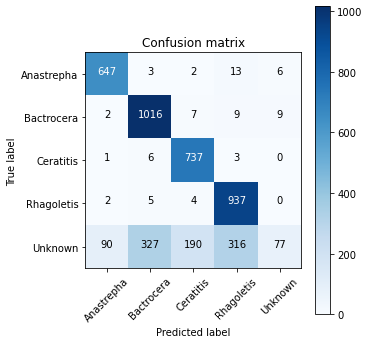

In [139]:
confusion = confusion_matrix(y_truth, y_openmax[0])
plt.figure(figsize=(5,5))
plot_confusion_matrix(confusion, openset_classes)  
plt.savefig("t0.pdf",bbox_inches = 'tight')

Confusion matrix, without normalization
[[612   0   0   1  58]
 [  0 965   0   3  75]
 [  0   1 716   0  30]
 [  1   0   1 910  36]
 [ 11  51  18  61 859]]


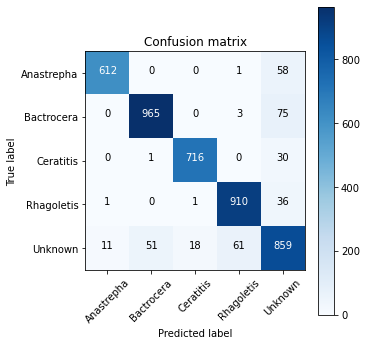

In [140]:
confusion = confusion_matrix(y_truth, y_openmax[8])
plt.figure(figsize=(5,5))
plot_confusion_matrix(confusion, openset_classes)  
plt.savefig("t098.pdf",bbox_inches = 'tight')